In [ ]:
! wget https://ai-data.obs.ru-moscow-1.hc.sbercloud.ru/МО_на_графах.zip -P ./data

In [ ]:
! unzip data/МО_на_графах.zip -d ./data

In [ ]:
!unzip data/ВК/hackathon_mos_sep2022.zip -d ./data

In [ ]:
vars =!ls data

In [ ]:
for i in vars:
    name = i[::-8]
    print(i)
    

In [94]:
vars

<function vars>

In [3]:
import pandas as pd
import plotly as pl
import numpy as np
import json
from collections import Counter

In [6]:
total_size = 0
batch = 10_000
total_pair_seq_mat = Counter()
dt = None
for f in pd.read_csv("data/FINAL_SEQUENCES_MATRIX.csv", sep='\t', chunksize=batch):
    total_size += f.shape[0] 
    f["s"] = f["SESSIONS_SEQUENCES"].apply(lambda x: json.loads(x.replace("'", '"')))
    #Очистка от данных с 1 состоянием и меньше
    f = f.drop(f.index[[bl<=1 for bl in [len(cn) for cn in f['s']]]],axis=0)
    #подсчет пар векторов переходов 
    for seq_list in f["s"]:
        for seq_ind in range(len(seq_list)-1):
            total_pair_seq_mat[(seq_list[seq_ind],seq_list[seq_ind+1])] +=1
    dt = f

(array([5.547255e+06, 8.400000e+01, 1.900000e+01, 8.000000e+00,
        9.000000e+00, 4.000000e+00, 4.000000e+00, 4.000000e+00,
        4.000000e+00, 4.000000e+00, 1.000000e+00, 2.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 2.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.00

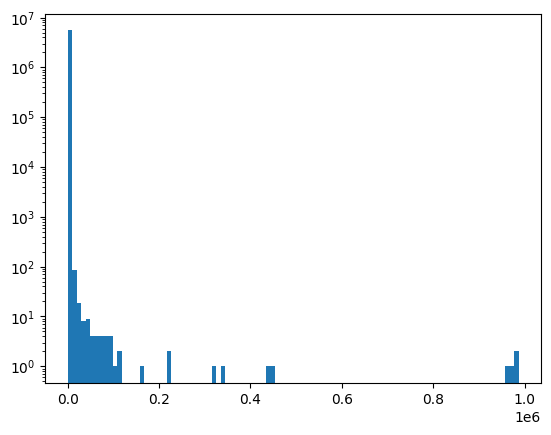

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
np_values=np.array(list(total_pair_seq_mat.values()))
np_values = np_values[np_values < 1e6]
plt.hist(np_values,bins=100,log=True)

In [7]:
total_size = 0
batch = 10_000
total_pair_seq = Counter()
dt = None
for f in pd.read_csv("data/FINAL_ALL_SEQUENCES_TRAINTEST.tsv", sep='\t', chunksize=batch):
    total_size += f.shape[0]
    
    
    f["s"] = f["SEQUENCE"].apply(lambda x: json.loads(x.replace("'", '"')))
    f = f.drop(f.index[[bl<=1 for bl in [len(cn) for cn in f['s']]]],axis=0)
    for seq_list in f["s"]:
        for seq_ind in range(len(seq_list)-1):
            total_pair_seq[(seq_list[seq_ind],seq_list[seq_ind+1])] +=1
    dt = f
# total_sequences = total_seq

In [ ]:
len(total_pair_seq)

In [ ]:
len(total_pair_seq_mat)

In [8]:
no_mat_dt = pd.DataFrame({"SEQ": list(total_pair_seq.keys()),
              "CNT": list(total_pair_seq.values())})
mat_dt = pd.DataFrame({"SEQ": list(total_pair_seq_mat.keys()),
              "CNT": list(total_pair_seq_mat.values())})
full_dt_seq = no_mat_dt.merge(mat_dt, on="SEQ", how='left')

In [9]:
full_dt_seq = full_dt_seq.fillna(0)

In [15]:
from pathlib import Path  
filepath = Path('data/seq_pair_count.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
full_dt_seq.rename(columns={"CNT_x":"CNT_SEQ","CNT_y":"CNT_SEQ_WITH_MAT"},inplace = True)
full_dt_seq.to_csv(filepath)

In [14]:
np.corrcoef(full_dt_seq["CNT_SEQ"],full_dt_seq["CNT_SEQ_WITH_MAT"])

array([[1.        , 0.94740637],
       [0.94740637, 1.        ]])

In [ ]:
full_dt_seq.head()

### зависимость благотвор от кол-ва переходов

In [4]:
seq_right = pd.read_csv("data/FINAL_ALL_SEQUENCES_TRAINTEST.tsv", sep='\t')
trg_left = pd.read_csv("data/FINAL_TARGETS_DATES_TRAINTEST.tsv", sep='\t')
    

In [5]:
seq_with_targets = trg_left.merge(seq_right, on="CLIENT_ID", how='left')
seq_with_targets = seq_with_targets.fillna('[]')
seq_with_targets["s"] = seq_with_targets["SEQUENCE"].apply(lambda x: json.loads(x.replace("'", '"')))
seq_with_targets = seq_with_targets.drop(seq_with_targets.index[[bl<=1 for bl in [len(cn) for cn in seq_with_targets['s']]]],axis=0)
seq_with_targets.head()

,CLIENT_ID,RETRO_DT,TARGET,SEQUENCE,s
0,1011725,20210501,0,"['358f1de5feb4209fae852fb0a61de5d8', '6760174c...","[358f1de5feb4209fae852fb0a61de5d8, 6760174c457..."
1,1018784,20210501,1,"['9a7670be67a118ddd4b30f5cdd3b035e', 'e5945238...","[9a7670be67a118ddd4b30f5cdd3b035e, e5945238cc6..."
2,1021812,20210501,0,"['e65bd9b13ec4a97ac7b912f37c3e36d4', '9a7670be...","[e65bd9b13ec4a97ac7b912f37c3e36d4, 9a7670be67a..."
3,1024003,20210501,0,"['489fed35d8b91d95691efab0215e46a8', '9b4b7f50...","[489fed35d8b91d95691efab0215e46a8, 9b4b7f50905..."
5,1026390,20210501,1,"['833f134928f303b5531209ff372ab4ce', 'b496d19e...","[833f134928f303b5531209ff372ab4ce, b496d19eb25..."


In [6]:
seq_with_targets["s_pair"] = seq_with_targets["s"].apply(lambda x : [(x[i],x[i+1]) 
                                                                     for i in range(len(x)-1)])
seq_with_targets.head()

,CLIENT_ID,RETRO_DT,TARGET,SEQUENCE,s,s_pair
0,1011725,20210501,0,"['358f1de5feb4209fae852fb0a61de5d8', '6760174c...","[358f1de5feb4209fae852fb0a61de5d8, 6760174c457...","[(358f1de5feb4209fae852fb0a61de5d8, 6760174c45..."
1,1018784,20210501,1,"['9a7670be67a118ddd4b30f5cdd3b035e', 'e5945238...","[9a7670be67a118ddd4b30f5cdd3b035e, e5945238cc6...","[(9a7670be67a118ddd4b30f5cdd3b035e, e5945238cc..."
2,1021812,20210501,0,"['e65bd9b13ec4a97ac7b912f37c3e36d4', '9a7670be...","[e65bd9b13ec4a97ac7b912f37c3e36d4, 9a7670be67a...","[(e65bd9b13ec4a97ac7b912f37c3e36d4, 9a7670be67..."
3,1024003,20210501,0,"['489fed35d8b91d95691efab0215e46a8', '9b4b7f50...","[489fed35d8b91d95691efab0215e46a8, 9b4b7f50905...","[(489fed35d8b91d95691efab0215e46a8, 9b4b7f5090..."
5,1026390,20210501,1,"['833f134928f303b5531209ff372ab4ce', 'b496d19e...","[833f134928f303b5531209ff372ab4ce, b496d19eb25...","[(833f134928f303b5531209ff372ab4ce, b496d19eb2..."


In [31]:
samp = seq_with_targets.sample(1000)

In [4]:
total_size = 0
batch = 10_000
total_seq_usr = Counter()
for f in pd.read_csv("data/FINAL_ALL_SEQUENCES_TRAINTEST.tsv", sep='\t', chunksize=batch):
    total_size += f.shape[0]
    f["s"] = f["SEQUENCE"].apply(lambda x: json.loads(x.replace("'", '"')))
    for seq, cnt in zip(*np.unique(np.concatenate(f["s"].values), return_counts=True)):
        total_seq_usr[seq] += cnt